## Task 1

step is 0
step is 500
step is 1000
step is 1500
step is 2000
step is 2500
step is 3000
step is 3500
step is 4000
step is 4500
step is 5000
step is 5500
step is 6000
6001
[0.07488831 0.0659356  0.08316078 ... 0.99974794 0.99975323 0.99974719]
6001
[0.02 0.02 0.02 ... 0.86 0.86 0.86]


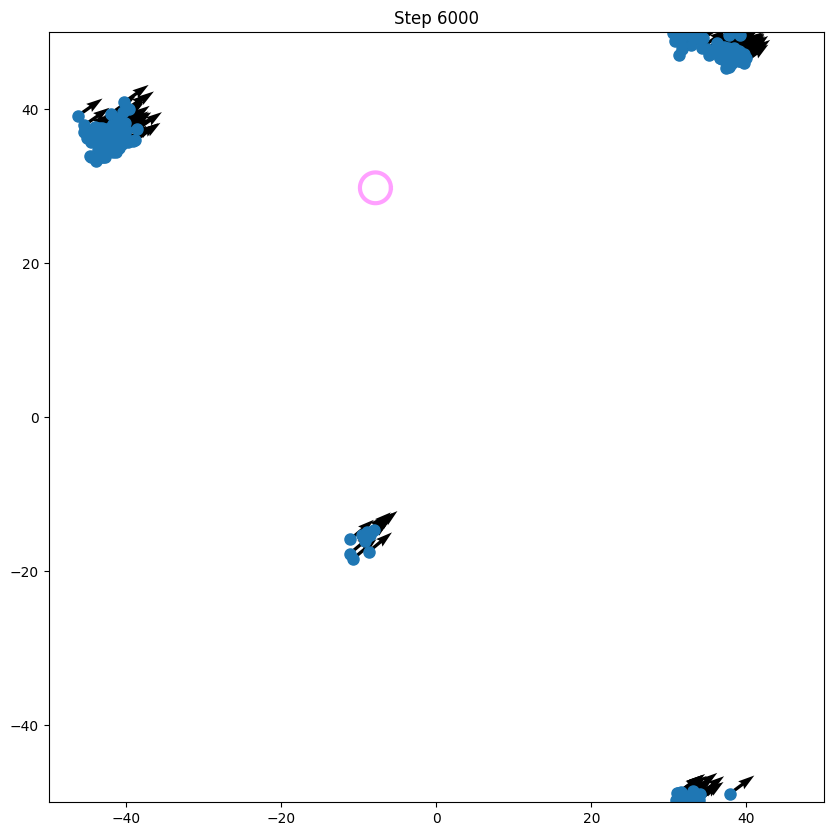

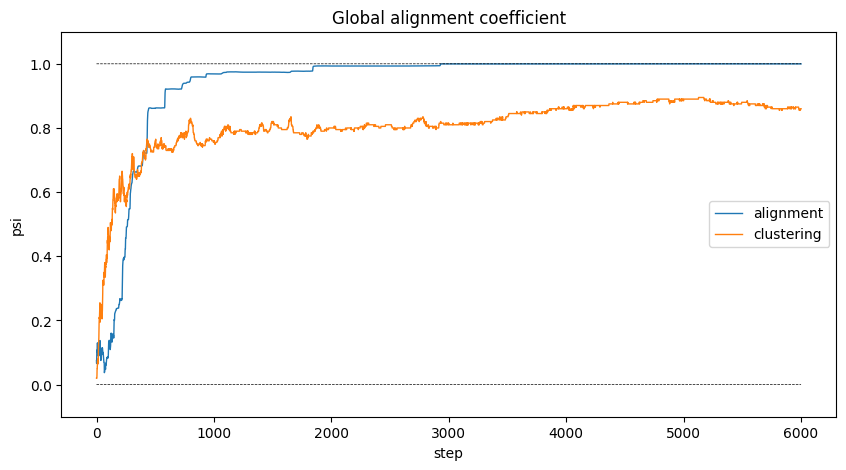

In [2]:
import math
import numpy as np 
from matplotlib import pyplot as plt
    

def replicas(x, y, L):
    """
    Function to generate replicas of a single particle.
    
    Parameters
    ==========
    x, y : Position.
    L : Side of the squared arena.
    """    
    xr = np.zeros(9)
    yr = np.zeros(9)

    for i in range(3):
        for j in range(3):
            xr[3 * i + j] = x + (j - 1) * L
            yr[3 * i + j] = y + (i - 1) * L
    
    return xr, yr

def pbc(x, y, L):
    """
    Function to enforce periodic boundary conditions on the positions.
    
    Parameters
    ==========
    x, y : Position.
    L : Side of the squared arena.
    """   
    
    outside_left = np.where(x < - L / 2)[0]
    x[outside_left] = x[outside_left] + L

    outside_right = np.where(x > L / 2)[0]
    x[outside_right] = x[outside_right] - L

    outside_up = np.where(y > L / 2)[0]
    y[outside_up] = y[outside_up] - L

    outside_down = np.where(y < - L / 2)[0]
    y[outside_down] = y[outside_down] + L
    
    return x, y

from functools import reduce

def interaction(x, y, theta, Rf, L):
    """
    Function to calculate the orientation at the next time step.
    
    Parameters
    ==========
    x, y : Positions.
    theta : Orientations.
    Rf : Flocking radius.
    L : Dimension of the squared arena.
    s : Discrete steps.
    """
    
    N = np.size(x)

    theta_next = np.zeros(N)
    
    # Preselect what particles are closer than Rf to the boundaries.
    replicas_needed = reduce( 
        np.union1d, (
            np.where(y + Rf > L / 2)[0], 
            np.where(y - Rf < - L / 2)[0],
            np.where(x + Rf > L / 2)[0],
            np.where(x - Rf > - L / 2)[0]
        )
    )

    for j in range(N):
        # Check if replicas are needed to find the nearest neighbours.
        if np.size(np.where(replicas_needed == j)[0]):
            # Use replicas.
            xr, yr = replicas(x[j], y[j], L)
            nn = []
            for nr in range(9):
                dist2 = (x - xr[nr]) ** 2 + (y - yr[nr]) ** 2 
                nn = np.union1d(nn, np.where(dist2 <= Rf ** 2)[0])
        else:
            dist2 = (x - x[j]) ** 2 + (y - y[j]) ** 2 
            nn = np.where(dist2 <= Rf ** 2)[0]
        
        # The list of nearest neighbours is set.
        nn = nn.astype(int)
        
        # Circular average.
        av_sin_theta = np.mean(np.sin(theta[nn]))
        av_cos_theta = np.mean(np.cos(theta[nn]))
        
        theta_next[j] = np.arctan2(av_sin_theta, av_cos_theta)
                   
    return theta_next



def global_alignment(theta):
    """
    Function to calculate the global alignment coefficient.

    Parameters
    ==========
    theta : Orientations.
    """

    N = np.size(theta)

    global_direction_x = np.sum(np.sin(theta))
    global_direction_y = np.sum(np.cos(theta))

    psi = np.sqrt(global_direction_x ** 2 + global_direction_y ** 2) / N

    return psi

from scipy.spatial import Voronoi, voronoi_plot_2d

def area_polygon(vertices):
    """
    Function to calculate the area of a Voronoi region given its vertices.

    Parameters
    ==========
    vertices : Coordinates (array, 2 dimensional).
    """
    N, dim = vertices.shape

    # dim是2，顶点按顺序排列
    A = 0
    for i in range(N - 1):
        A += np.abs(
            vertices[-1, 0] * (vertices[i, 1] - vertices[i + 1, 1]) +
            vertices[i, 0] * (vertices[i + 1, 1] - vertices[-1, 1]) +
            vertices[i + 1, 0] * (vertices[-1, 1] - vertices[i, 1])
        )
    A *= 0.5
    return A

def global_clustering(x, y, Rf, L):
    """
    Function to calculate the global alignment coefficient.
    
    Parameters
    ==========
    x, y : Positions.
    Rf : Flocking radius.
    L : Dimension of the squared arena.
    """
    
    N = np.size(x)
    
    # Use the replicas of all points to calculate Voronoi for 
    # a more precise estimate.
    points = np.zeros([9 * N, 2])

    for i in range(3):
        for j in range(3):
            s = 3 * i + j
            points[s * N:(s + 1) * N, 0] = x + (j - 1) * L
            points[s * N:(s + 1) * N, 1] = y + (i - 1) * L

    # The format of points is the one needed by Voronoi.
    # points[:, 0] contains the x coordinates
    # points[:, 1] contains the y coordinates
   
    vor = Voronoi(points)     
    '''
    vertices = vor.vertices  # Voronoi vertices.
    regions = vor.regions  # Region list. 
    # regions[i]: list of the vertices indices for region i.
    # If -1 is listed: the region is open (includes point at infinity).
    point_region = vor.point_region  # Region associated to input point.
    '''
   
    # Consider only regions of original set of points (no replicas).
    list_regions = vor.point_region[4 * N:5 * N]
    
    c = 0

    for i in list_regions:
        indices = vor.regions[i]
        # print(f'indices = {indices}')
        if len(indices) > 0:
            if np.size(np.where(np.array(indices) == -1)[0]) == 0:
                # Region is finite.
                # Calculate area.
                A = area_polygon(vor.vertices[indices,:])
                if A < np.pi * Rf ** 2:
                    c += 1
                    
    c = c / N
                   
    return c



N = 200  # Number of particles.
L = 100  # Dimension of the squared arena.
v = 1  # Speed.
Rf = 2  # Flocking radius.
eta = 0.01  # Noise.  Try values: 0.01, 0.3, 1.0, 2 * np.pi
dt = 1  # Time step.
T = 6000 # total time steps

# Random position.
x = (np.random.rand(N) - 0.5) * L  # in [-L/2, L/2]
y = (np.random.rand(N) - 0.5) * L  # in [-L/2, L/2]

# Random orientation.
theta = 2 * (np.random.rand(N) - 0.5) * np.pi  # in [-pi, pi]

time_steps = []
psi = np.zeros(T+1)  # Records the global alignment.
c = np.zeros(T+1)  # Records the global clustering.

fig, ax = plt.subplots(figsize=(10, 10))

for step in range(T + 1):

    x_center = np.mean(x)
    y_center = np.mean(y)
    
    # Check whether plot configuration.
    if step in [0, 2000, 4000, 6000]:
        ax.clear()  # Clear previous plot.
        ax.plot(x, y, '.', markersize=16)
        ax.quiver(x, y, np.cos(theta), np.sin(theta))
        ax.plot(x_center +Rf * np.cos(2 * np.pi * np.arange(360) / 360),
                y_center + Rf * np.sin(2 * np.pi * np.arange(360) / 360),
                '-', color='#FFA0FF', linewidth=3)
        ax.set_xlim([-L / 2, L / 2])
        ax.set_ylim([-L / 2, L / 2])
        ax.set_title(f'Step {step}')
        
        plt.savefig(f'particle_figure_timestep_{step}.png')
    
    # DEBUG
    if step % 500 == 0:
        print(f'step is {step}')

    psi[step] = global_alignment(theta)
    c[step] = global_clustering(x, y, Rf, L)
    time_steps.append(step)

    # update velocity and postion
    dtheta = eta * (np.random.rand(N) - 0.5) * dt
    theta = interaction(x, y, theta, Rf, L) + dtheta
    x = x + v * np.cos(theta)
    y = y + v * np.sin(theta)
    x, y = pbc(x, y, L)

# DEBUG
print(len(psi))
print(psi)
print(len(c))
print(c)

plt.figure(figsize=(10, 5))
plt.plot(psi, '-', linewidth=1, label='alignment')
plt.plot(c, '-', linewidth=1, label='clustering')
plt.plot(0 * psi, '--', color='k', linewidth=0.5)
plt.plot(0 * psi + 1, '--', color='k', linewidth=0.5)
plt.title('Global alignment coefficient')
plt.legend()
plt.xlabel('step')
plt.ylabel('psi')
plt.ylim([-0.1, 1.1])
plt.savefig(f'Global alignment and clustering coefficient.png')


## Task 2

step is 0
step is 500
step is 1000
step is 1500
step is 2000
step is 2500
step is 3000
step is 3500
step is 4000
step is 4500
step is 5000
step is 5500
step is 6000
6001
[0.02303433 0.02339295 0.0213683  ... 0.96936837 0.97028678 0.9680197 ]
6001
[0.035 0.025 0.06  ... 0.5   0.51  0.5  ]


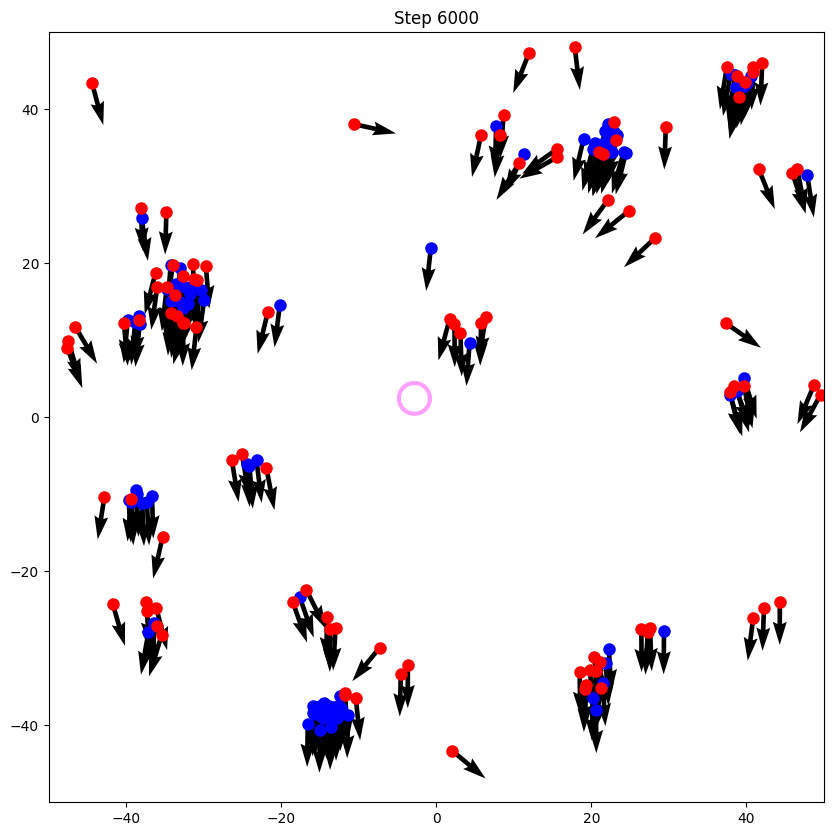

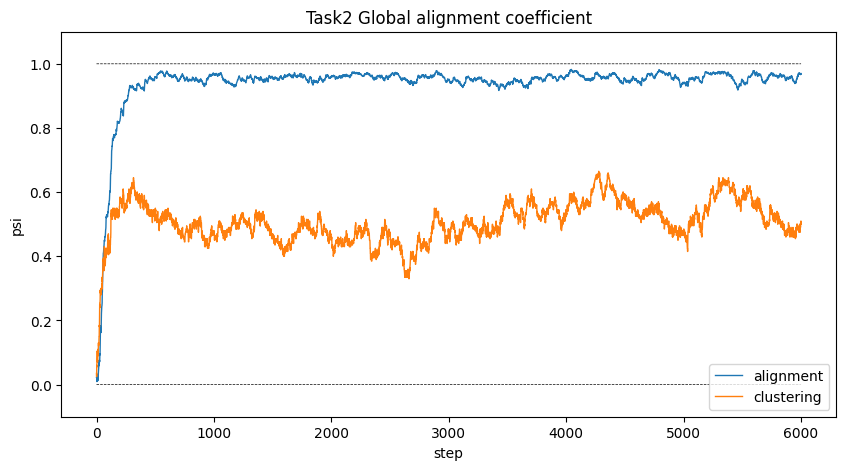

In [3]:
import math
import numpy as np
from matplotlib import pyplot as plt


def replicas(x, y, L):
    """
    Function to generate replicas of a single particle.

    Parameters
    ==========
    x, y : Position.
    L : Side of the squared arena.
    """
    xr = np.zeros(9)
    yr = np.zeros(9)

    for i in range(3):
        for j in range(3):
            xr[3 * i + j] = x + (j - 1) * L
            yr[3 * i + j] = y + (i - 1) * L

    return xr, yr


def pbc(x, y, L):
    """
    Function to enforce periodic boundary conditions on the positions.

    Parameters
    ==========
    x, y : Position.
    L : Side of the squared arena.
    """

    outside_left = np.where(x < -L / 2)[0]
    x[outside_left] = x[outside_left] + L

    outside_right = np.where(x > L / 2)[0]
    x[outside_right] = x[outside_right] - L

    outside_up = np.where(y > L / 2)[0]
    y[outside_up] = y[outside_up] - L

    outside_down = np.where(y < -L / 2)[0]
    y[outside_down] = y[outside_down] + L

    return x, y


def interaction(x, y, theta, Rf, L):
    """
    Function to calculate the orientation at the next time step.

    Parameters
    ==========
    x, y : Positions.
    theta : Orientations.
    Rf : Flocking radius.
    L : Dimension of the squared arena.
    s : Discrete steps.
    """

    N = np.size(x)
    theta_next = np.zeros(N)

    # Preselect what particles are closer than Rf to the boundaries.
    replicas_needed = np.unique(np.concatenate((
        np.where(y + Rf > L / 2)[0],
        np.where(y - Rf < -L / 2)[0],
        np.where(x + Rf > L / 2)[0],
        np.where(x - Rf > -L / 2)[0]
    )))

    for j in range(N):
        # Check if replicas are needed to find the nearest neighbours.
        if np.size(np.where(replicas_needed == j)[0]) > 0:
            # Use replicas.
            xr, yr = replicas(x[j], y[j], L)
            nn = []
            for nr in range(9):
                dist2 = (x - xr[nr]) ** 2 + (y - yr[nr]) ** 2
                nn = np.unique(np.concatenate((nn, np.where(dist2 <= Rf ** 2)[0])))
        else:
            dist2 = (x - x[j]) ** 2 + (y - y[j]) ** 2
            nn = np.where(dist2 <= Rf ** 2)[0]

        # The list of nearest neighbours is set.
        nn = nn.astype(int)

        # Circular average.
        av_sin_theta = np.mean(np.sin(theta[nn]))
        av_cos_theta = np.mean(np.cos(theta[nn]))

        theta_next[j] = np.arctan2(av_sin_theta, av_cos_theta)

    return theta_next


def global_alignment(theta):
    """
    Function to calculate the global alignment coefficient.

    Parameters
    ==========
    theta : Orientations.
    """

    N = np.size(theta)

    global_direction_x = np.sum(np.sin(theta))
    global_direction_y = np.sum(np.cos(theta))

    psi = np.sqrt(global_direction_x ** 2 + global_direction_y ** 2) / N

    return psi


from scipy.spatial import Voronoi


def area_polygon(vertices):
    """
    Function to calculate the area of a Voronoi region given its vertices.

    Parameters
    ==========
    vertices : Coordinates (array, 2 dimensional).
    """
    N, dim = vertices.shape

    # dim是2，顶点按顺序排列
    A = 0
    for i in range(N - 1):
        A += np.abs(
            vertices[-1, 0] * (vertices[i, 1] - vertices[i + 1, 1]) +
            vertices[i, 0] * (vertices[i + 1, 1] - vertices[-1, 1]) +
            vertices[i + 1, 0] * (vertices[-1, 1] - vertices[i, 1])
        )
    A *= 0.5
    return A


def global_clustering(x, y, Rf, L):
    """
    Function to calculate the global alignment coefficient.

    Parameters
    ==========
    x, y : Positions.
    Rf : Flocking radius.
    L : Dimension of the squared arena.
    """

    N = np.size(x)

    # Use the replicas of all points to calculate Voronoi for
    # a more precise estimate.
    points = np.zeros([9 * N, 2])

    for i in range(3):
        for j in range(3):
            s = 3 * i + j
            points[s * N:(s + 1) * N, 0] = x + (j - 1) * L
            points[s * N:(s + 1) * N, 1] = y + (i - 1) * L

    vor = Voronoi(points)

    # Consider only regions of original set of points (no replicas).
    list_regions = vor.point_region[4 * N:5 * N]

    c = 0
    for i in list_regions:
        indices = vor.regions[i]
        if len(indices) > 0:
            if np.size(np.where(np.array(indices) == -1)[0]) == 0:
                # Region is finite.
                # Calculate area.
                A = area_polygon(vor.vertices[indices, :])
                if A < np.pi * Rf ** 2:
                    c += 1

    c = c / N
    return c


N = 200  # Number of particles.
L = 100  # Dimension of the squared arena.
v = 1  # Speed.
Rf = 2  # Flocking radius.
eta1 = 0.01  # Noise for first sub - population
eta2 = 0.3  # Noise for second sub - population
dt = 1  # Time step.
T = 6000  # total time steps

# Random position.
x = (np.random.rand(N) - 0.5) * L  # in [-L/2, L/2]
y = (np.random.rand(N) - 0.5) * L  # in [-L/2, L/2]

# Random orientation.
theta = 2 * (np.random.rand(N) - 0.5) * np.pi  # in [-pi, pi]

time_steps = []
psi = np.zeros(T + 1)  # Records the global alignment.
c = np.zeros(T + 1)  # Records the global clustering.

fig, ax = plt.subplots(figsize=(10, 10))

for step in range(T + 1):
    x_center = np.mean(x)
    y_center = np.mean(y)

    # Check whether plot configuration.
    if step in [0, 2000, 4000, 6000]:
        ax.clear()
        # Plot first sub - population (blue)
        ax.plot(x[0:100], y[0:100], '.', markersize=16, color='blue')
        ax.quiver(x[0:100], y[0:100], np.cos(theta[0:100]), np.sin(theta[0:100]))
        # Plot second sub - population (red)
        ax.plot(x[100:200], y[100:200], '.', markersize=16, color='red')
        ax.quiver(x[100:200], y[100:200], np.cos(theta[100:200]), np.sin(theta[100:200]))
        ax.plot(x_center + Rf * np.cos(2 * np.pi * np.arange(360) / 360),
                y_center + Rf * np.sin(2 * np.pi * np.arange(360) / 360),
                '-', color='#FFA0FF', linewidth=3)
        ax.set_xlim([-L / 2, L / 2])
        ax.set_ylim([-L / 2, L / 2])
        ax.set_title(f'Step {step}')
        plt.savefig(f'Task2_particle_figure_timestep_{step}.png')

    # DEBUG
    if step % 500 == 0:
        print(f'step is {step}')

    psi[step] = global_alignment(theta)
    c[step] = global_clustering(x, y, Rf, L)
    time_steps.append(step)

    # update velocity and position
    dtheta1 = eta1 * (np.random.rand(100) - 0.5) * dt
    dtheta2 = eta2 * (np.random.rand(100) - 0.5) * dt
    dtheta = np.concatenate((dtheta1, dtheta2))
    theta = interaction(x, y, theta, Rf, L) + dtheta
    x = x + v * np.cos(theta)
    y = y + v * np.sin(theta)
    x, y = pbc(x, y, L)

# DEBUG
print(len(psi))
print(psi)
print(len(c))
print(c)

plt.figure(figsize=(10, 5))
plt.plot(psi, '-', linewidth=1, label='alignment')
plt.plot(c, '-', linewidth=1, label='clustering')
plt.plot(0 * psi, '--', color='k', linewidth=0.5)
plt.plot(0 * psi + 1, '--', color='k', linewidth=0.5)
plt.title('Task2 Global alignment coefficient')
plt.legend(loc='lower right')
plt.xlabel('step')
plt.ylabel('psi')
plt.ylim([-0.1, 1.1])
plt.savefig(f'Task2 Global alignment and clustering coefficient.png')